# Variational Autoencoders

Autoencoders work by training encoders to reduce samples input to them to a lower-dimensionality "latent space" and training decoders to reconstruct the original inputs from values in that latent space. They generate images by taking random inputs sampled from latent space and "reconstructing" images from them. In practice, variational autoencoders respond better to random inputs than conventional autoencoders by ensuring continuity in latent space. Let's demonstrate using the MNIST digits dataset built into Keras. We'll first build a convolutional autoencoder and use it to generate new images. Then we'll do the same with a variational convolutional autoencoder and compare the difference. Start by loading the dataset.

In [1]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Plot the first 30 digits in the dataset.

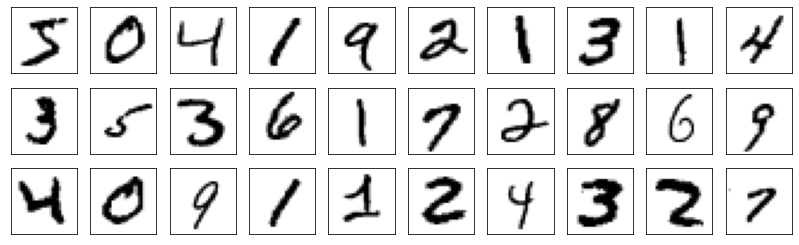

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 10, figsize=(14, 4.2), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap=plt.cm.gray_r)

## Conventional autoencoder

Create an autoencoder that uses a CNN to encode images as vectors of 32 floating-point values in latent space and another CNN to decode the vectors and reconstruct the original images.

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.layers import GlobalAveragePooling2D

encoder = Sequential()
encoder.add(Conv2D(16, (3, 3), activation='relu', strides=2, padding='same', input_shape=(28, 28, 1)))
encoder.add(Conv2D(32, (3, 3), activation='relu', strides=2, padding='same'))
encoder.add(Conv2D(32, (3, 3), activation='relu', strides=2, padding='same'))
encoder.add(GlobalAveragePooling2D()) # 32

decoder = Sequential()
decoder.add(Dense(3 * 3 * 16, activation='relu'))
decoder.add(Reshape((3, 3, 16)))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu'))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(1, (3, 3), strides=2, activation='relu', padding='same'))
decoder.add(Reshape((28, 28)))

model = Sequential([encoder, decoder])
model.compile(loss='mse', optimizer='adam')

Train the model to encode and then decode (reconstruct) the training images.

In [4]:
hist = model.fit(x_train, x_train, epochs=20, validation_data=(x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0358 - val_loss: 0.0221
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0195 - val_loss: 0.0170
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0163 - val_loss: 0.0149
Epoch 4/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0126 - val_loss: 0.0123
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 8/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 9/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 10/20
1875/1875 [==============================] - 10s 5ms/step - l

Plot the training and validation loss.

[]

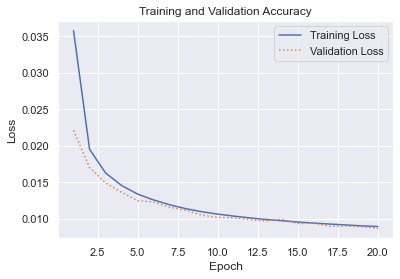

In [5]:
import seaborn as sns
sns.set()

err = hist.history['loss']
val_err = hist.history['val_loss']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training Loss')
plt.plot(epochs, val_err, ':', label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()

Plot the first 10 images in the test dataset and the reconstructed versions of the same images.

1/1 [==============================] - 0s 110ms/step


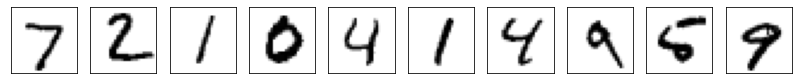

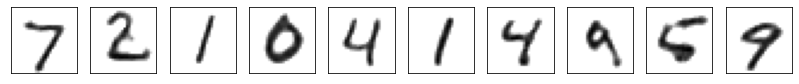

In [6]:
sns.reset_orig()
fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i], cmap=plt.cm.gray_r)

y = model.predict(x_test[:10])
fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(y[i], cmap=plt.cm.gray_r)

Now generate 10 random input vectors and construct images from them.

1/1 [==============================] - 0s 67ms/step


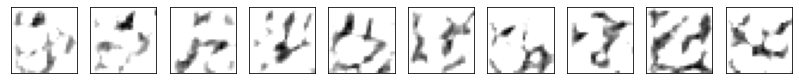

In [7]:
import numpy as np

inputs = np.random.normal(size=[10, 32])
outputs = decoder.predict(inputs)

fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(outputs[i], cmap=plt.cm.gray_r)

The decoder did a reasonable job of reconstructing images from the test data, but it performed poorly when presented with random inputs. To help understand why, let's encode the first 5,000 digits in the training dataset and use PCA to visualize the encodings in 2 dimensions.

157/157 [==============================] - 0s 881us/step


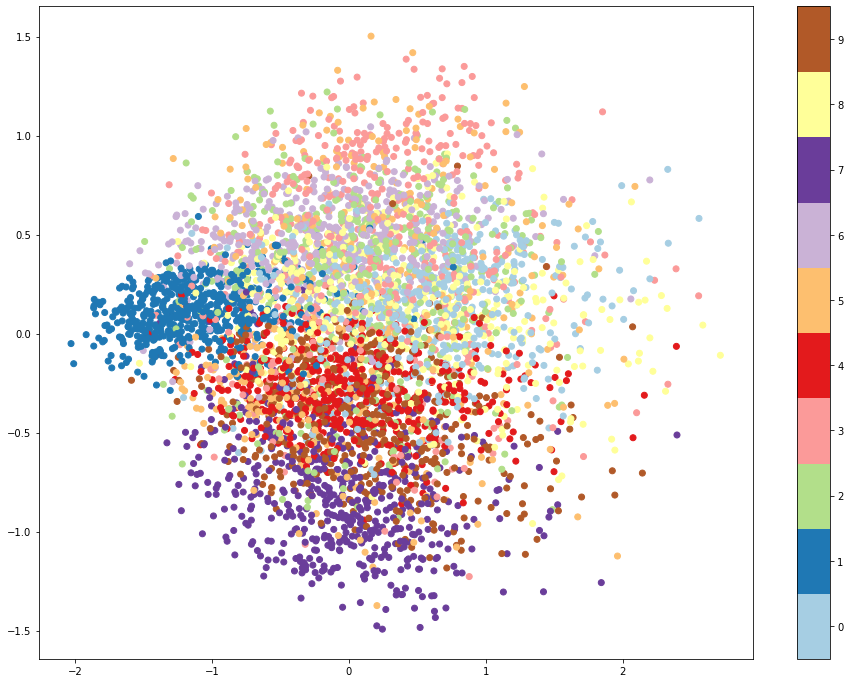

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
encodings = encoder.predict(x_train[:5000])
pca_encodings = pca.fit_transform(encodings)

plt.figure(figsize=(16, 12))
plt.scatter(pca_encodings[:, 0], pca_encodings[:, 1], c=y_train[:5000], cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

The vectors representing the digits in latent space are discrete points that don't conform to a normal distribution. That's the problem that variational autoencoders were invented to solve.

## Variational convolutional autoencoder

Rather than convert an input into a discrete vector in latent space, a variational autoencoder converts an input into a mean and a variance representing a normal distribution. Consequently, latent space is regularized such that a random input generates meaningful output. Let's turn our convolutional autoencoder into a variational encoder and see if it can generate new digits from random inputs. Begin by defining a custom layer that takes vectors representing means and variances as input and returns vectors randomly sampled from the corresponding latent space.

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Sampling(Layer):
    def call(self, inputs):
        z_mean = inputs[0]
        z_log_var = inputs[1]
        return tf.random.normal(tf.shape(z_log_var)) * tf.exp(z_log_var / 2) + z_mean

Use Keras's functional API to define an encoder that's similar to the one in the previous example, but that outputs vectors sampled from a Guassian distribution defined by the output from a pair of `Dense` layers.

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

encoder_input = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', strides=2, padding='same')(encoder_input) # 14 x 14
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(x) # 7 x 7
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(x) # 3 x 3
x = GlobalAveragePooling2D()(x) # 32

# Use two Dense layers as output from the previous layer, and input the two
# outputs from the Dense layers to a Sampling layer
z_mean = Dense(8)(x)
z_log_var = Dense(8)(x)
encoder_output = Sampling()([z_mean, z_log_var])

# Define an encoder model that accepts 28x28 images as input and whose
# output is the two vectors generated by the Sampling layer
encoder = Model(encoder_input, encoder_output)

Define a decoder that's identical to the one in the previous example. Then create an autoencoder and include a custom loss function so that during training, loss will be calculated as the sum of MSE and the output from the custom loss function.

In [11]:
decoder = Sequential()
decoder.add(Dense(3 * 3 * 16, activation='relu'))
decoder.add(Reshape((3, 3, 16)))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu'))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(1, (3, 3), strides=2, activation='relu', padding='same'))
decoder.add(Reshape((28, 28)))

model = Model(encoder_input, decoder(encoder(encoder_input)))
model.compile(loss='mse', optimizer='adam')

# From "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurelien Geron
z_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.exp(z_log_var) - tf.square(z_mean), axis=-1)
model.add_loss(tf.reduce_mean(z_loss) / (28 * 28)) # Divide by 784 to compute mean loss across all pixels

Train the model to encode and then decode (reconstruct) the training images.

In [12]:
hist = model.fit(x_train, x_train, epochs=20, validation_data=(x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0606 - val_loss: 0.0518
Epoch 2/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0491 - val_loss: 0.0473
Epoch 3/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0464 - val_loss: 0.0457
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0451 - val_loss: 0.0443
Epoch 5/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0440 - val_loss: 0.0432
Epoch 6/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0432 - val_loss: 0.0424
Epoch 7/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0426 - val_loss: 0.0421
Epoch 8/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0422 - val_loss: 0.0414
Epoch 9/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0418 - val_loss: 0.0411
Epoch 10/20
1875/1875 [==============================] - 11s 6ms/step - l

Plot the training and validation loss.

[]

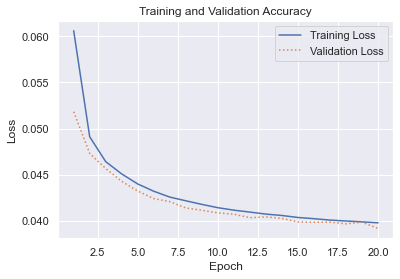

In [13]:
sns.set()
err = hist.history['loss']
val_err = hist.history['val_loss']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training Loss')
plt.plot(epochs, val_err, ':', label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()

Plot the first 10 images in the test dataset and the reconstructed versions of the same images.

1/1 [==============================] - 0s 125ms/step


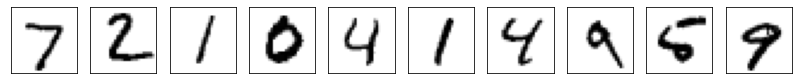

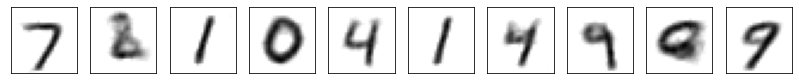

In [14]:
sns.reset_orig()
fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i], cmap=plt.cm.gray_r)

y = model.predict(x_test[:10])
fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(y[i], cmap=plt.cm.gray_r)

Generate 10 random input vectors and construct images from them.

1/1 [==============================] - 0s 65ms/step


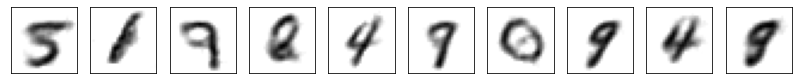

In [15]:
inputs = np.random.normal(size=[10, 8])
outputs = decoder.predict(inputs)

fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(outputs[i], cmap=plt.cm.gray_r)

Encode the first 5,000 digits in the training dataset and use PCA to visualize the encodings in 2 dimensions.

157/157 [==============================] - 0s 874us/step


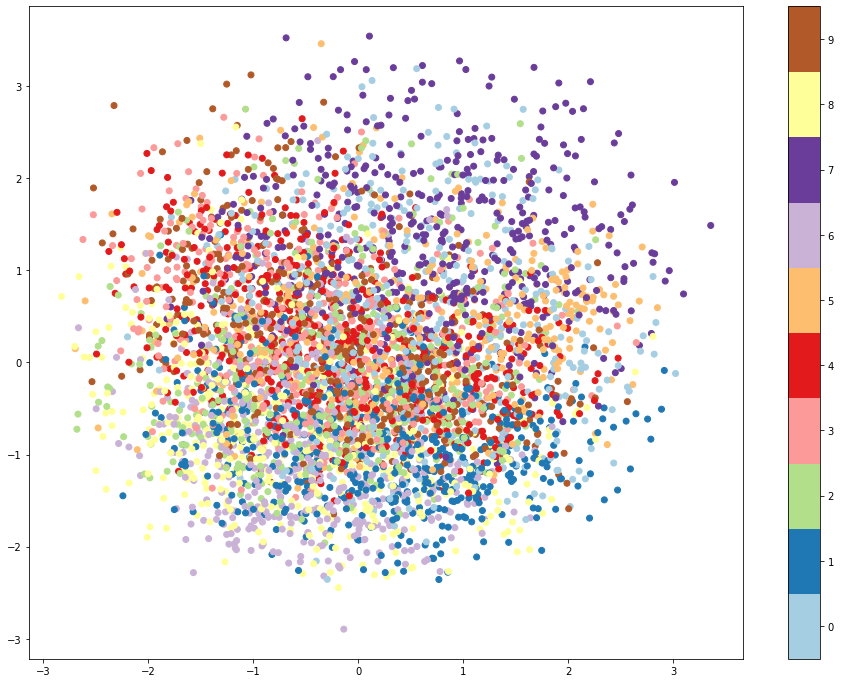

In [16]:
pca = PCA(n_components=2, random_state=0)
encodings = encoder.predict(x_train[:5000])
pca_encodings = pca.fit_transform(encodings)

plt.figure(figsize=(16, 12))
plt.scatter(pca_encodings[:, 0], pca_encodings[:, 1], c=y_train[:5000], cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

The variational autoencoder performs much better when constructing images from random inputs because latent space resembles a normal distribution. It doesn't make sense to generate new digits by morphing existing digits, but imagine training a variational autoencoder on facial images rather than digits. By inputting a random vector, you could generate an entirely new face that has never been seen before.